# Churn Prediction in Telecommunications
Churn means customers are leaving the network, which means revenue loss. The essence of a churn prediction model is to avoid losing too much revenue.
For a first-case churn analysis, we will want to check that churn rate is not same or higher than customer acquisition rate. For a continued analysis, the business KPI sets the churn rate limit, for example, less than 15%.

The data in this study is a quarterly report from a fictive telecom company that provides home phone service and internet subscriptions. We will treat the data as a first-case churn analysis study. We inspect and explore the data to understand the factors that affect churn, train a model to predict churn, test the model and verify accuracy.

## Table of Contents
1. [Data Wrangling](#data-wrangling)
    * [Modules and Clients](#modules-and-clients)
    * [Data Loading](#data-loading)
    * [Data Inspection](#data-inspection)
    * [Data Cleaning](#data-cleaning)
2. [Exploratory Data Analysis](#exploratory-data-analysis-eda)
    * [Churn vs Acquisition Rate](#churn-vs-acquisition-rate)
    * [Churn Count for each Category](#churn-count-for-each-category)
    * [Relationship between churn and numeric variables](#relationship-between-churn-and-numeric-variables)
    * [Correlation between Variables](#correlation-between-variables)
3. [Feature Engineering](#feature-engineering)
    * [Random sampling](#random-sampling)
    * [Resolving class imbalance 1](#resolving-class-imbalance-part-1)
    * [Feature Importance](#feature-importance)
    * [Resolving class imbalance 2](#resolving-class-imbalance-part-2)
4. [Churn Prediction](#churn-prediction)
    * [Logistic Regression](#logistic-regression)
    * [SVM classifier](#support-vector-machines-svm-classifier)
    * [Random Forest Classifier](#random-forest-classifier)
    * [KNN](#k-nearest-neighbors)
    * [Gaussian Naive Bayes](#gaussian-naive-bayes)
    * [ROC Curve](#roc-curve)
5. [Conclusion](#conclusion)
6. [Addendum](#addendum)
    * [Actions for Customers Predicted to Churn](#actions-for-customers-predicted-to-churn)

## Data Wrangling
The data is loaded, inspected, and cleaned.

### Modules and Clients
Here, the Python packages needed are imported.

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
import numpy as np

### Data Loading

In [2]:
# load data into a dataframe
telco_df = pd.read_csv('wa_telco.csv')

### Data Inspection

In [3]:
# check columns
telco_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Here's the description of the columns in the data:
1. CustomerID: Unique customer identification number
2. Tenure: Total amount of months with the company by the end of the quarter.
3. Gender: Customer Gender
4. SeniorCitizen: If age is 65 or over
5. Partner: If customer has a partner
6. Dependents: If living with any dependents (children, parents, grandparents, etc.)
7. PhoneService: If subscribed to home phone service.
8. MultipleLines: If subscribed to multiple telephone lines.
9. InternetService: If subscribed to internet service.
10. OnlineSecurity: If subscribed to additional online security service
11. OnlineBackup: If subscribed to additional online backup service. 
12. DeviceProtection: If subscribed to additional device protection plan for internet equipment. 
13. TechSupport: If subscribed to additional technical support plan with reduced wait times.
14. StreamingTV*: Uses internet service to stream third party television programing.*
15. StreamingMovies*: Uses internet service to stream third party movies.*
16. Contract: Current contract type
17. PaperlessBilling: If billing is paperless
18. PaymentMethod: Current payment method
19. MonthlyCharges: Total monthly charge for all services
20. TotalCharges: Sum total of charges, calculated at the end of the quarter specified
21. Churn: If left the company
* means the company does not charge an additional fee for this service. 

In [4]:
# summary
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# inspect first five rows
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Cleaning

#### Rename columns to match data dictionary

In [6]:
telco_df.rename(columns={'customerID':'CustomerID', 'gender':'Gender', 'tenure':'Tenure'}, inplace=True)

#### Correct TotalCharges datatype

In [7]:
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce', downcast='integer')

#### Treat null TotalCharges values

In [8]:
# count null total charges values
telco_df['TotalCharges'].isna().sum()

11

In [9]:
telco_df.loc[telco_df['TotalCharges'].isna(), ['Tenure', 'MonthlyCharges', 'TotalCharges']]

,Tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


The total charges are unavailable for customers with tenure of 0 months, that is, the most recent customers. In this case, the total charges will be same as the monthly charges

In [10]:
# fill null total charges with monthly charges
telco_df.loc[telco_df['TotalCharges'].isna(), 'TotalCharges'] = telco_df.loc[telco_df['TotalCharges'].isna(),
                                                                             'MonthlyCharges']

#### Set correct column datatypes

In [11]:
# create lists for the various data types
string_columns = ['Gender', 'InternetService', 'Contract', 'PaymentMethod']
category_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'PaperlessBilling', 'Churn']
integer_columns = ['Tenure']
float_columns = ['MonthlyCharges', 'TotalCharges']

In [12]:
# create data type mapping dictionaries
string_mapping = {0:'No', 1:'Yes'}
numeric_mapping = {'No':0, 'Yes':1}
other_mapping = {'No phone service':'No', 'No internet service':'No'}

In [13]:
for col in category_columns:
    telco_df[col] = pd.Categorical(telco_df[col])
    telco_df[col] = telco_df[col].replace(other_mapping).replace(string_mapping)

#### Set id column as index

In [14]:
telco_df.set_index('CustomerID', inplace=True)

#### Inspect cleaned dataframe

In [15]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Gender            7043 non-null   object  
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   Tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   object  
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   object  
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod 

## Exploratory Data Analysis (EDA)

### Churn vs Acquisition Rate
This data is a report from the last quarter (3 months). The proportion of customers who churned *(churn rate)* will be compared against the proportion of customers who joined the network in the last three months *(acquisition rate)*. If the churn rate is higher than the acquisition rate, then churn is too high and needs to be mitigated as soon as possible.

In [16]:
# calculate churn rate
churn_rate = telco_df['Churn'].value_counts(normalize=True)

In [17]:
# calculate acquisition rate
joined_last_quarter = telco_df['Tenure'] <=3
acquisition_rate = joined_last_quarter.map({True:'Yes', False:'No'}).value_counts(normalize=True)

In [18]:
# compare churn and acquisition in the last quarter
churn_vs_acquisition = pd.concat([churn_rate, acquisition_rate], axis=1, ignore_index=False,
                                 keys=['Churn','Acquisition'])
churn_vs_acquisition

,Churn,Acquisition
No,0.73463,0.849212
Yes,0.26537,0.150788


<Axes: >

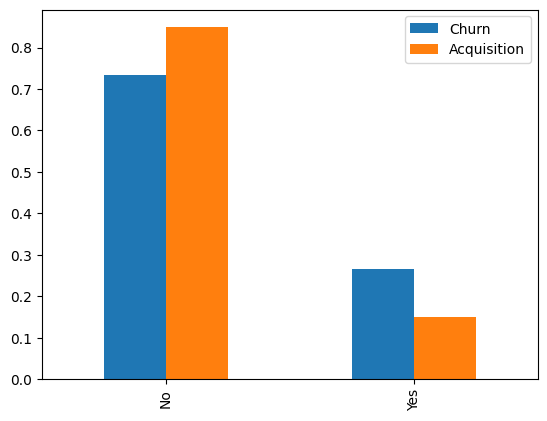

In [19]:
# plot bar chart of churn vs acquisition
churn_vs_acquisition.plot.bar()

More than a quarter of customers churned last quarter while 15% more were added to the network. The churn rate is higher than acquisition rate, hence, this model is very important to mitigate revenue loss.

### Churn Count for each Category

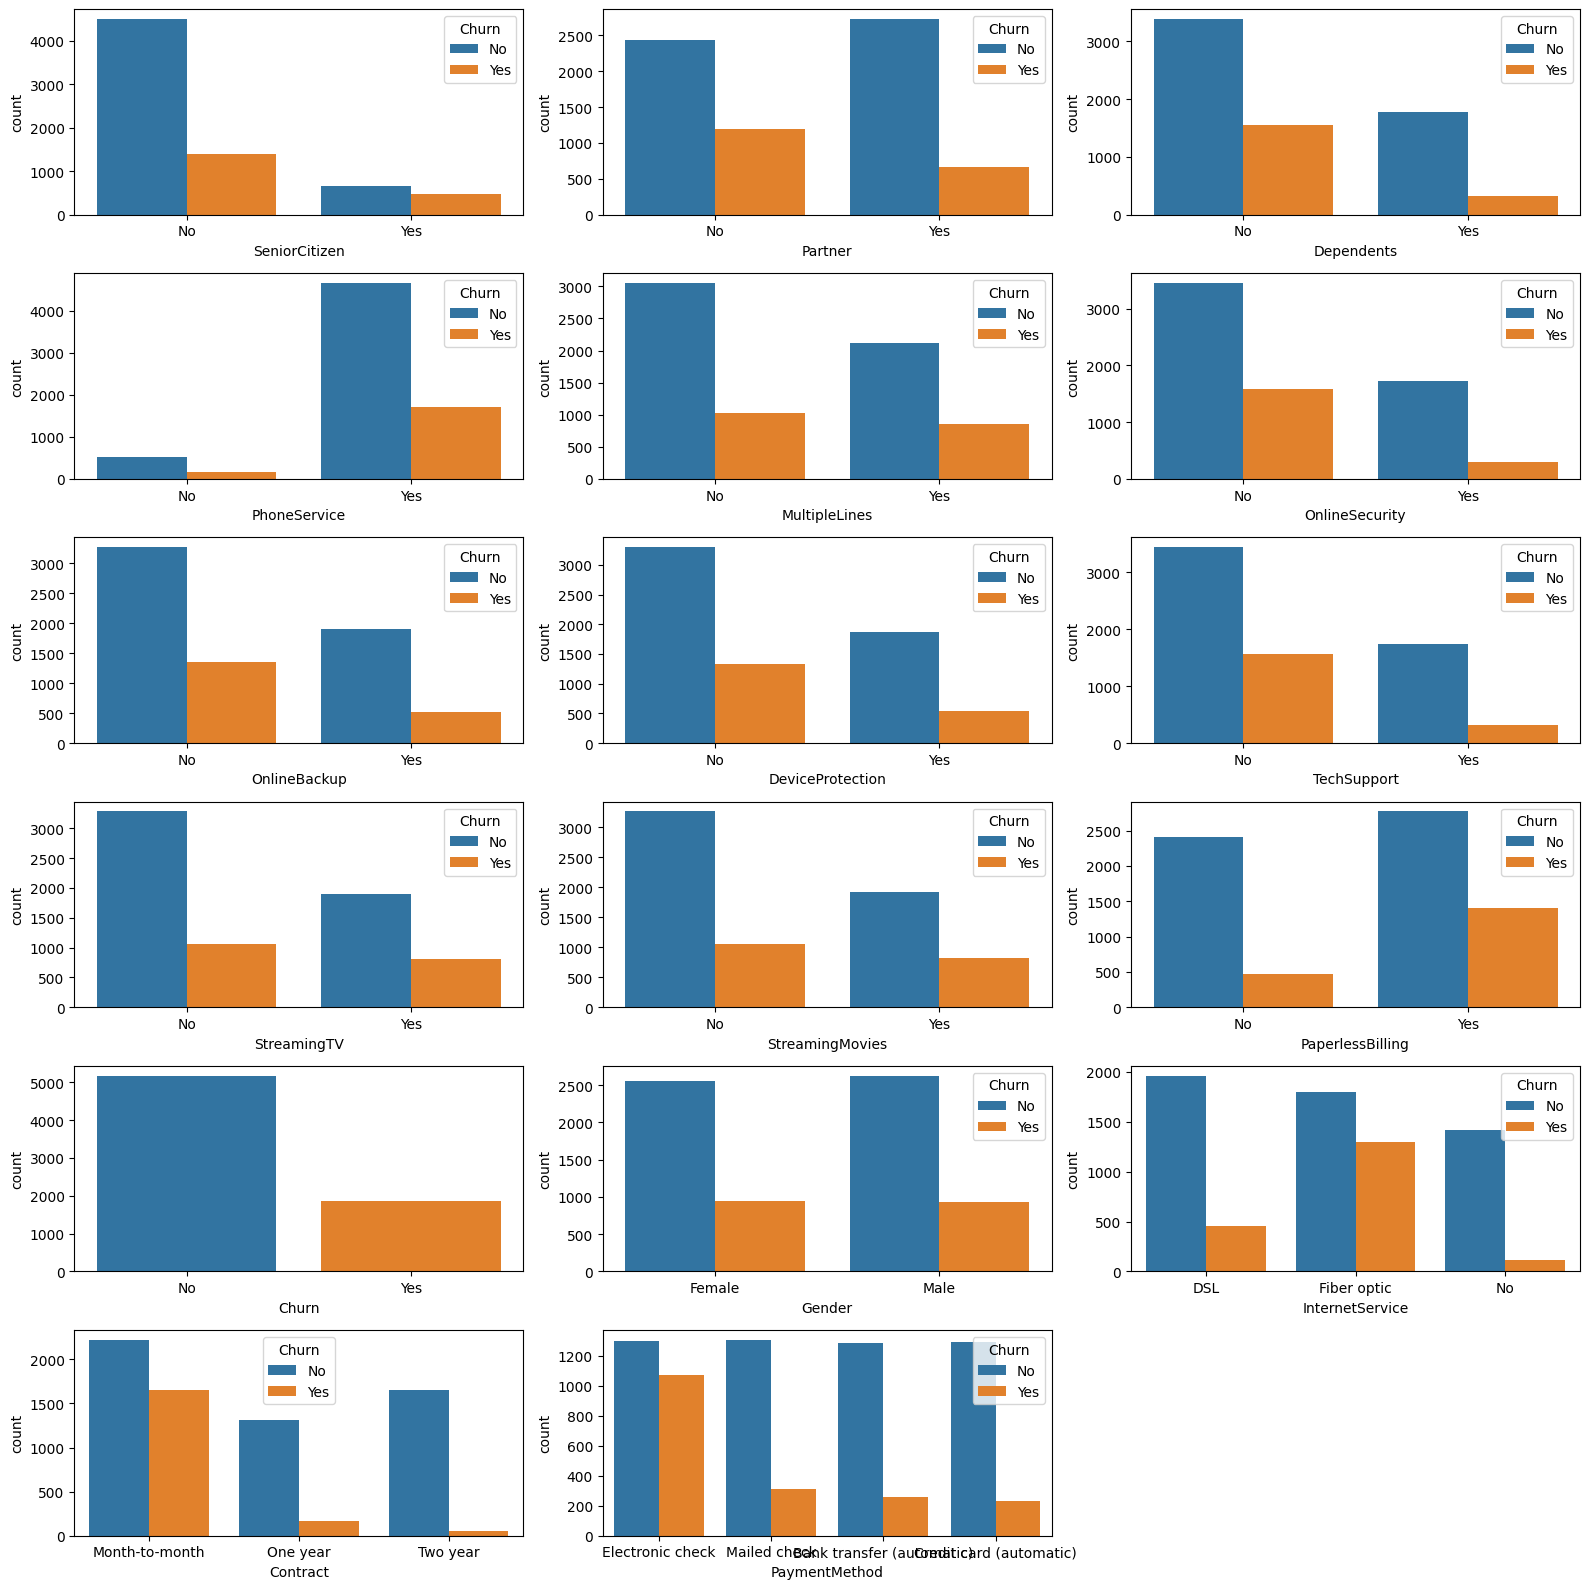

In [20]:
# set up plot figure, number of rows and columns
num_cols = 3
num_rows = 6
fig, axes = plt.subplots(num_rows, num_cols,figsize=[16,16])

# flatten the axes for iteration
axes = axes.flatten()

# join string and category column lists
object_columns = category_columns + string_columns

# plot count plot for each object column with churn as hue
for i, column in enumerate(object_columns):
    sns.countplot(data=telco_df, x=column, ax=axes[i], hue='Churn')

# delete empty axes
for j in range(len(object_columns), num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()

This is a quick look through all category and text columns. Here, we see that we have higher churn among senior citizens, customers without partners, customers with multiple lines, customers who stream tv and movies, customers with paperless billing, customers with fiber optic internet service, customers on a month-to-month contract, and finally customers who pay for the telco service with an electronic check.

### Relationship between Churn and Numeric Variables

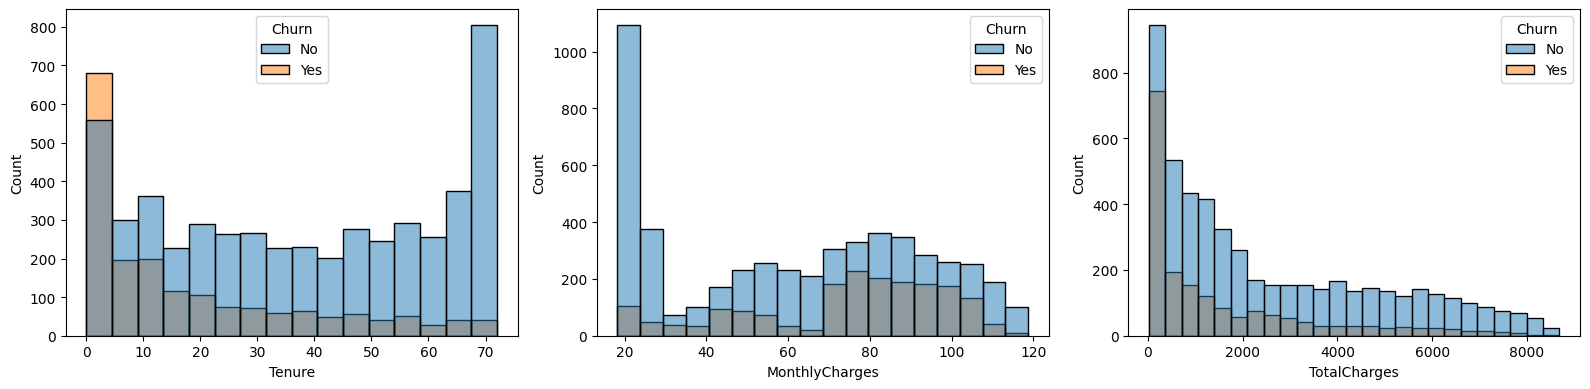

In [21]:
# set up plot figure, number of rows and columns
num_cols = 3
num_rows = 1
fig, axes = plt.subplots(num_rows, num_cols,figsize=[16,4])

# flatten the axes for iteration
axes = axes.flatten()

# join integer and float column lists
numeric_columns = integer_columns + float_columns

# plot histogram for each object column with churn as hue
for i, column in enumerate(numeric_columns):
    sns.histplot(data=telco_df, x=column, ax=axes[i], hue='Churn')

# delete empty axes
for j in range(len(numeric_columns), num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()

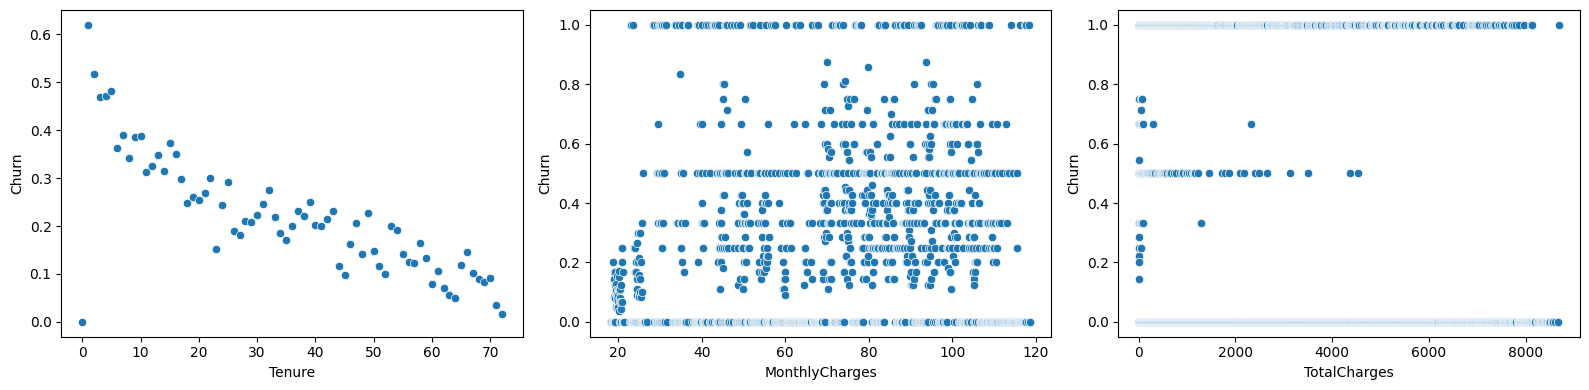

In [22]:
# set up plot figure, number of rows and columns
num_cols = 3
num_rows = 1
fig, axes = plt.subplots(num_rows, num_cols,figsize=[16,4])

# flatten the axes for iteration
axes = axes.flatten()

# plot scatter plot of churn against numeric columns
for i, column in enumerate(numeric_columns):
    scatter_df = telco_df.copy()
    scatter_df['Churn'] = scatter_df['Churn'].replace(numeric_mapping).astype(float)
    scatter_df = scatter_df.groupby(column, as_index=False).Churn.mean()
    sns.scatterplot(data=scatter_df, x=column, ax=axes[i], y='Churn')

# delete empty axes
for j in range(len(numeric_columns), num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()

We also see here that churn and tenure have a negative relationship. This means that more recent customers are most likely to churn so we need to be more interested in newer customers.

### Correlation between Variables

In [23]:
# Generating the dummy variables
for col in telco_df.columns:
    try: telco_df[col] = telco_df[col].replace(numeric_mapping).astype(int)
    except: pass
telco_df = pd.get_dummies(data=telco_df, columns=string_columns, drop_first=True)

In [24]:
corr_df = telco_df.corr().round(2)

<Axes: >

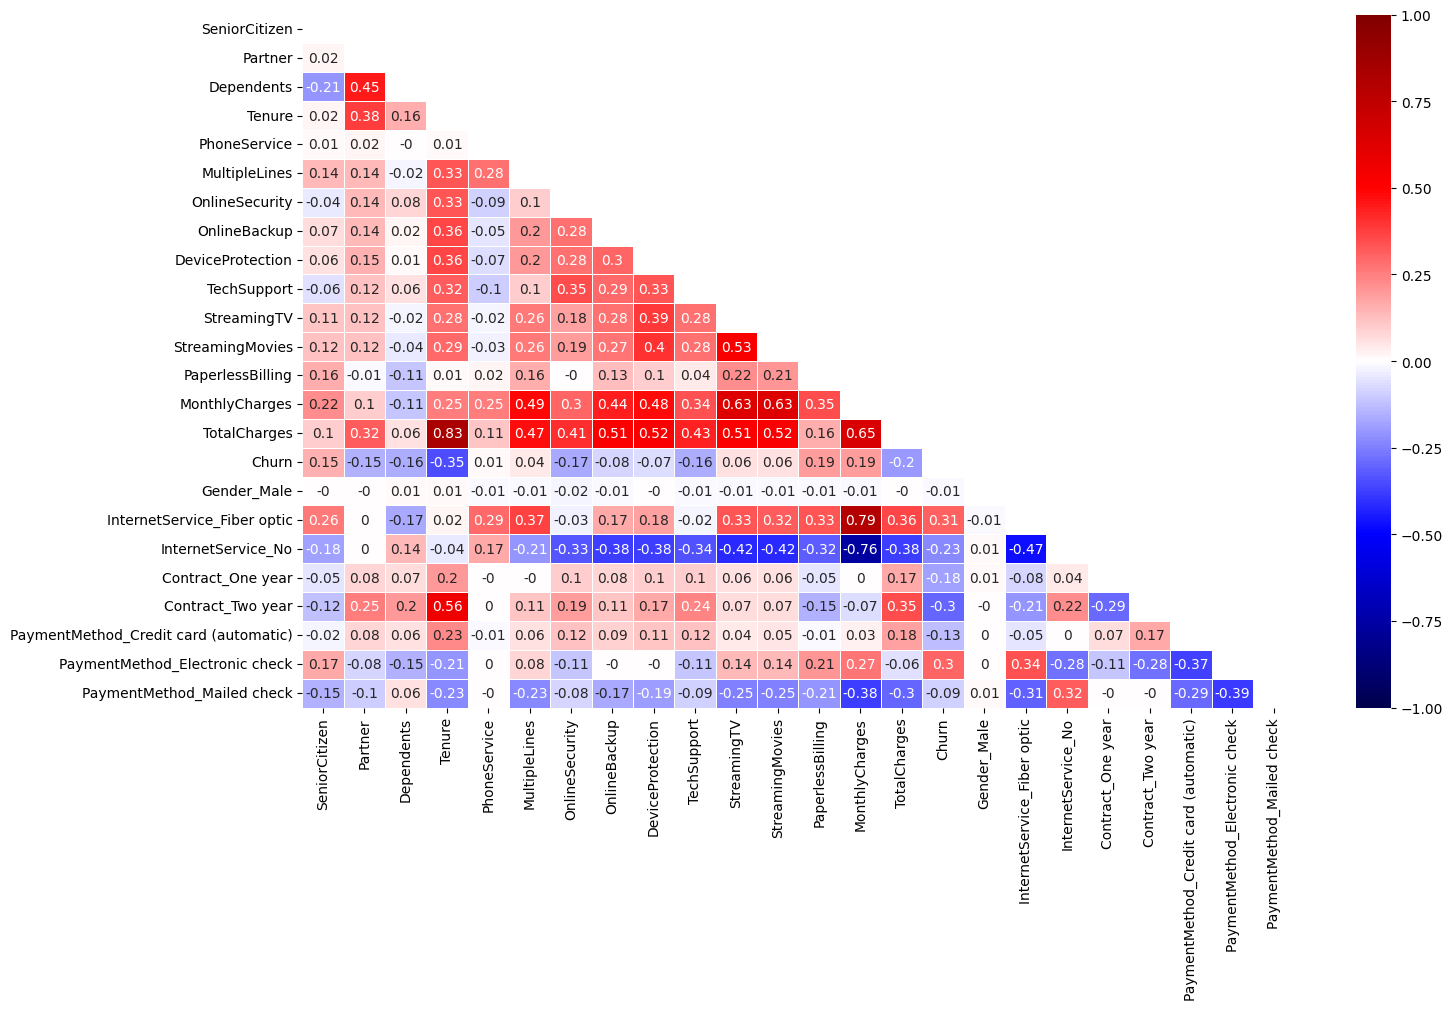

In [25]:
f, ax = plt.subplots(figsize=(16, 9))
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Setup the correlation matrix as a heatmap with diverging colors
sns.heatmap(corr_df, mask=mask, cmap='seismic', annot=True, vmax=1, vmin=-1, linewidths=.5)

Apart from obvious correlations between tenure and total charges, and monthly charges and total charges, there is a negative relationship between no internet usage and monthly charges and a positive relationship between fibre optic internet service and monthly charges. There is also a positive relationship between monthly charges and streaming. This is of note because we earlier saw that customers who stream and customers who use fiber optic are more likely to churn.

We already know that the company does not charge an additional fee for streaming so not much can be done in terms of pricing by the business. However, the business can look into the pricing strategy for their fiber optic service. A hypothesis will be that fiber optic is overpriced, causing customers who use that service to churn. They can also offer streaming bundles with incentives.

## Feature Engineering

### Random sampling
The data is first randomized.

In [26]:
# randomise data
telco_df = telco_df.sample(frac=1, random_state=42)

### Resolving class imbalance Part 1

In [27]:
# count churn class
telco_df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

There are more non-churners than churners and this can create class imbalance in the model such that the model will be biased towards accurate predictions for non-churners.
To mitigate against this, we will use equal stratified sampling to sample equal number of churners and non-churners to train the model with. We will sample 1600 customers in each group

In [28]:
# create training group
train_grp = telco_df.groupby('Churn').sample(n=1600,random_state=42)

In [29]:
# create test group
test_grp = telco_df.drop(train_grp.index)

In [30]:
X_train = train_grp.drop('Churn',axis=1)
y_train = train_grp['Churn']
X_test = test_grp.drop('Churn',axis=1)
y_test = test_grp['Churn']

### Feature Importance

The results from the EDA show that the following features, in no particular order, are important in predicting churn:

1. SeniorCitizen
2. Partner
3. MultipleLines
4. StreamingTV
5. StreamingMovies
6. PaperlessBilling
7. InternetService(_Fiber optic)
8. Contract(_One year, _Two year, _Month-to-month)
9. PaymentMethod_Electronic check
10. Tenure

We will also use the Random Forest algorithm to find feature importance and compare.

In [31]:
# instantiate and fit a random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

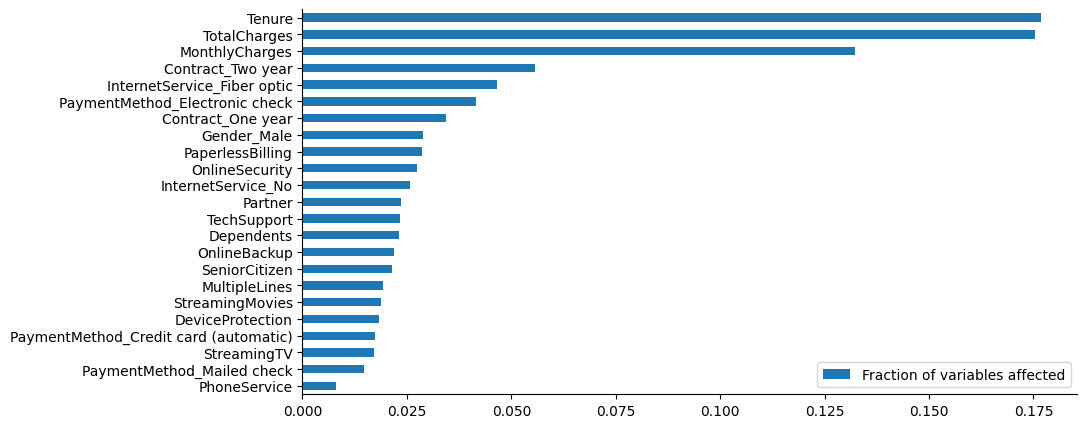

In [32]:
# Plot the feature importance
feat_scores= pd.DataFrame({"Fraction of variables affected" : rf.feature_importances_},
                          index = telco_df.drop('Churn', axis=1).columns)
feat_scores= feat_scores.sort_values(by = "Fraction of variables affected")
feat_scores.plot(kind = "barh", figsize = (10, 5))
sns.despine()

The results are similar although random forest places less importance on senior citizens, streaming methods, and multiple lines. We will not use monthly and total charges as they are highly correlatable with other important features. We will go ahead with the results of the EDA and select those features to build the churn model with. 

In [33]:
# select important features
X = telco_df.loc[:, ['SeniorCitizen', 'Partner', 'MultipleLines', 'StreamingTV', 'StreamingMovies',
                            'PaperlessBilling', 'InternetService_Fiber optic', 'Contract_One year',
                            'Contract_Two year', 'PaymentMethod_Electronic check', 'Tenure', 'Churn']]

### Resolving Class Imbalance Part 2

In [34]:
# create training group
train_grp = X.groupby('Churn').sample(n=1600,random_state=42)

In [35]:
# create test group
test_grp = X.drop(train_grp.index)

In [36]:
X_train = train_grp.drop('Churn',axis=1)
y_train = train_grp['Churn']
X_test = test_grp.drop('Churn',axis=1)
y_test = test_grp['Churn']

## Churn Prediction

Precision is the ratio of true negatives to predicted negatives and false positives to predicted positives. Recall is the ratio of true negatives to actual negatives and true positives to actual positives. Accuracy is the ratio of true negatives and true positives to the total sample. F-beta score can be interpreted as a weighted harmonic mean of the precision and recall where an F-beta score reaches its best value at 1 and worst score at 0.

Here are the formulas:
1. accuracy = (tn+tp)/len(y_predict)
2. precision_0 = tn/(fn+tn); precision_1 = fp/(fp+tp)
3. recall_0 = tn/(tn+fp); recall_1 = tp/(fn+tp)

The recall will be the most important metric we look at (since we want to know how close our results will be to actual values), followed by accuracy.

### Logistic Regression

In [37]:
# instantiate and fit a Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [38]:
# predict churn on test group
y_predict = model_LR.predict(X_test)

In [39]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      3574
           1       0.18      0.78      0.29       269

    accuracy                           0.73      3843
   macro avg       0.58      0.76      0.56      3843
weighted avg       0.92      0.73      0.80      3843



In [40]:
# confusion matrix
print(confusion_matrix(y_test, y_predict))

[[2603  971]
 [  58  211]]


### Support Vector Machines (SVM) Classifier

In [41]:
# instantiate, calibrate and fit a support vector classifier
model_svm = LinearSVC(max_iter=50000, dual=True)
model_svm = CalibratedClassifierCV(model_svm)
model_svm.fit(X_train, y_train)

c:\Users\iolowoye\Anaconda3\envs\streamlit\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\iolowoye\Anaconda3\envs\streamlit\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\iolowoye\Anaconda3\envs\streamlit\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\iolowoye\Anaconda3\envs\streamlit\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\iolowoye\Anaconda3\envs\streamlit\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(estimator=LinearSVC(dual=True, max_iter=50000))

In [42]:
# predict churn on test group
y_predict = model_svm.predict(X_test)

In [43]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3574
           1       0.18      0.78      0.29       269

    accuracy                           0.73      3843
   macro avg       0.58      0.75      0.56      3843
weighted avg       0.92      0.73      0.80      3843



In [44]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[2604  970]
 [  59  210]]


### Random Forest Classifier

In [45]:
# instantiate and fit a random forest classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
# predict test group
y_predict = model_rf.predict(X_test)

In [47]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.70      0.82      3574
           1       0.16      0.75      0.26       269

    accuracy                           0.70      3843
   macro avg       0.57      0.72      0.54      3843
weighted avg       0.92      0.70      0.78      3843



In [48]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[2508 1066]
 [  68  201]]


### K-Nearest Neighbors

In [49]:
# instantiate and fit a knn classifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [50]:
# predict test group
y_predict = model_knn.predict(X_test)

In [51]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3574
           1       0.17      0.60      0.26       269

    accuracy                           0.77      3843
   macro avg       0.57      0.69      0.56      3843
weighted avg       0.91      0.77      0.82      3843



In [52]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[2784  790]
 [ 108  161]]


### Gaussian Naive Bayes

In [53]:
# instantiate and fit a gnb model
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)

GaussianNB()

In [54]:
# predict test group
y_predict = model_gnb.predict(X_test)

In [55]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76      3574
           1       0.14      0.84      0.25       269

    accuracy                           0.64      3843
   macro avg       0.56      0.73      0.50      3843
weighted avg       0.92      0.64      0.72      3843



In [56]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[2220 1354]
 [  42  227]]


### ROC Curve

In [57]:
# ROC curve

fpr1, tpr1, thresh1 = roc_curve(y_test, model_LR.predict_proba(X_test)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, model_svm.predict_proba(X_test)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], pos_label = 1)
fpr4, tpr4, thresh4 = roc_curve(y_test, model_knn.predict_proba(X_test)[:, 1], pos_label = 1)
fpr5, tpr5, thresh5 = roc_curve(y_test, model_gnb.predict_proba(X_test)[:, 1], pos_label = 1)


In [58]:
# AUC score

auc_score1 = roc_auc_score(y_test, model_LR.predict_proba(X_test)[:, 1])
auc_score2 = roc_auc_score(y_test, model_svm.predict_proba(X_test)[:, 1])
auc_score3 = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
auc_score4 = roc_auc_score(y_test, model_knn.predict_proba(X_test)[:, 1])
auc_score5 = roc_auc_score(y_test, model_gnb.predict_proba(X_test)[:, 1])

print("Logistic Regression: ", auc_score1) # Logistic Regression
print("Support Vector Machine: ", auc_score2) # Support Vector Machine
print("Random Forest: ", auc_score3) # Random Forest
print("K-Nearest Neighbors: ", auc_score4) # K-Nearest Neighbors
print("Naive Bayes: ", auc_score5) # Naive Bayes

Logistic Regression:  0.8286530352421348
Support Vector Machine:  0.8285843857849856
Random Forest:  0.797938123955956
K-Nearest Neighbors:  0.7380643557456475
Naive Bayes:  0.8185366016022368


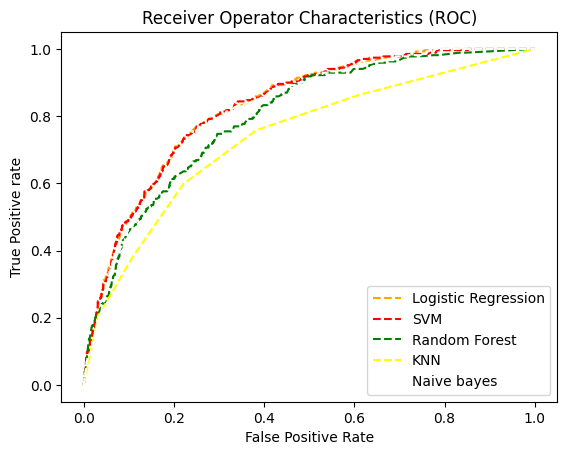

In [59]:
plt.plot(fpr1, tpr1, linestyle = "--", color = "orange", label = "Logistic Regression")
plt.plot(fpr2, tpr2, linestyle = "--", color = "red", label = "SVM")
plt.plot(fpr3, tpr3, linestyle = "--", color = "green", label = "Random Forest")
plt.plot(fpr4, tpr4, linestyle = "--", color = "yellow", label = "KNN")
plt.plot(fpr5, tpr5, linestyle = "--", color = "white", label = "Naive bayes")

plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
plt.savefig('ROC', dpi = 300)
plt.show()

## Conclusion

The Logistic Regression model gave the best model result followed closely by SVM with 83.6% and 83.5% accuracy respectively. This model can be used with new input data in the future (e.g 1 month from now) to predict customers who may churn, offer them incentives and targeted marketing campaigns based on their interests (e.g. from customer segmentation)

In [60]:
# instantiate and fit a Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [61]:
# predict churn on test group
y_predict = model_LR.predict(X_test)

In [62]:
# classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      3574
           1       0.18      0.78      0.29       269

    accuracy                           0.73      3843
   macro avg       0.58      0.76      0.56      3843
weighted avg       0.92      0.73      0.80      3843



In [63]:
# confusion matrix
print(confusion_matrix(y_test, y_predict))

[[2603  971]
 [  58  211]]


## Addendum

Now that we have predicted customers likely to churn, we can look at the features of these customers and flag them for certain incentives.

Customers with partners and dependents can be targeted for family bundle subscriptions, those with multiple lines can be targeted for line consolidation, those subscribed to online services, tech support and device protection can be offered incentives in those categories, streamers can be offered limited-time streaming bundles, those on monthly contracts can be incentivised to move to yearly contracts.

Finally, customers who generally pay with electronic checks should be surveyed to know why they choose to leave afterwards.

### Actions for Customers Predicted to Churn

To illustrate this, we assume that `y_test` does not exist and `X_test` is new data that we have predicted. Here are actions to take for customers in `X_test`.

In [64]:
# churn flag for predicted customers
predicted_df = pd.DataFrame(data=y_predict, index=X_test.index, columns=['PredictedChurn'])
X_test = telco_df.loc[telco_df.index.isin(X_test.index), :].drop('Churn', axis=1)
predicted_df = pd.concat([X_test, predicted_df], axis=1, ignore_index=False)

In [65]:
# filter to customers predicted to churn
churn_predicted_df = predicted_df.loc[predicted_df['PredictedChurn']==1, :]

#### Family bundle subscriptions

In [66]:
# customers to target for family bundles
family_bundles = churn_predicted_df.loc[(churn_predicted_df['Partner']==1)
                                        | (churn_predicted_df['Dependents']==1), :].index
', '.join(family_bundles)

'3192-LNKRK, 2672-TGEFF, 3679-XASPY, 5219-YIPTK, 2018-PZKMU, 1074-AMIOH, 5922-ABDVO, 1173-NOEYG, 3207-OYBWH, 1304-BCCFO, 0455-XFASS, 4273-MBHYA, 5600-KTXFM, 7055-HNEOJ, 8800-ZKRFW, 7929-DMBCV, 9626-VFRGG, 4929-XIHVW, 4927-WWOOZ, 3841-CONLJ, 5117-IFGPS, 0410-IPFTY, 8699-ASUFO, 1728-CXQBE, 4741-WWJQZ, 9800-ONTFE, 1465-VINDH, 3130-ICDUP, 7159-FVYPK, 6366-XIVKZ, 7126-RBHSD, 3001-UNBTL, 3780-DDGSE, 7343-EOBEU, 5498-TXHLF, 3496-LFSZU, 8849-AYPTR, 3466-WAESX, 1355-KUSBG, 1174-FGIFN, 9103-CXVOK, 7905-NJMXS, 1035-IPQPU, 6439-LAJXL, 6078-VESFR, 6704-UTUKK, 0096-BXERS, 6507-DTJZV, 9469-WEJBT, 5066-GFJMM, 9957-YODKZ, 3807-XHCJH, 7145-FEJWU, 6710-HSJRD, 9897-KXHCM, 7734-DBOAI, 8445-DNBAE, 3167-SNQPL, 4039-HEUNW, 9168-INPSZ, 8356-WUAOJ, 6100-QQHEB, 9314-IJWSQ, 7240-FQLHE, 9286-DOJGF, 2277-DJJDL, 4468-KAZHE, 9332-GYWLO, 8981-FJGLA, 1100-DDVRV, 5046-NUHWD, 6476-YHMGA, 5886-VLQVU, 5016-IBERQ, 2207-QPJED, 7821-DPRQE, 4983-CLMLV, 3062-ICYZQ, 2233-FAGXV, 2937-FTHUR, 8785-CJSHH, 5916-QEWPT, 9518-XXBXE, 234

#### Line consolidation

In [67]:
# customers to reach for line consolidation
line_consolidation = churn_predicted_df.loc[churn_predicted_df['MultipleLines']==1, :].index
', '.join(line_consolidation)

'5914-DVBWJ, 2672-TGEFF, 2869-ADAWR, 5219-YIPTK, 9277-JOOMO, 5922-ABDVO, 1173-NOEYG, 8535-SFUTN, 3207-OYBWH, 7354-OIJLX, 9129-UXERG, 3088-LHEFH, 5277-ZLOOR, 8800-ZKRFW, 9133-AYJZG, 9626-VFRGG, 6400-BWQKW, 5928-QLDHB, 3466-RITXD, 4927-WWOOZ, 2014-MKGMH, 3898-GUYTS, 5117-IFGPS, 5144-TVGLP, 8818-DOPVL, 8699-ASUFO, 8713-IGZSO, 2545-EBUPK, 1728-CXQBE, 0637-KVDLV, 7610-TVOPG, 9167-APMXZ, 9800-ONTFE, 1465-VINDH, 3130-ICDUP, 7159-FVYPK, 7126-RBHSD, 3001-UNBTL, 2985-FMWYF, 7343-EOBEU, 5498-TXHLF, 7966-YOTQW, 3466-WAESX, 4137-BTIKL, 6857-VWJDT, 7858-GTZSP, 1355-KUSBG, 1174-FGIFN, 7905-NJMXS, 7251-LJBQN, 4910-GMJOT, 7673-LPRNY, 9281-OFDMF, 5834-ASPWA, 4132-KALRO, 9508-ILZDG, 1035-IPQPU, 0096-BXERS, 4060-LDNLU, 9957-YODKZ, 7145-FEJWU, 6710-HSJRD, 6198-ZFIOJ, 3162-KKZXO, 8445-DNBAE, 3167-SNQPL, 4039-HEUNW, 9094-AZPHK, 9168-INPSZ, 2823-LKABH, 6100-QQHEB, 0581-MDMPW, 9314-IJWSQ, 8161-QYMTT, 7240-FQLHE, 9286-DOJGF, 2495-KZNFB, 2277-DJJDL, 2692-PFYTJ, 8623-ULFNQ, 2277-VWCNI, 8981-FJGLA, 0106-GHRQR, 371

#### Online, Tech, Device Support

In [68]:
# customers to target for online services, tech and device support
support = churn_predicted_df.loc[(churn_predicted_df['InternetService_Fiber optic']==1)
                                 | (churn_predicted_df['OnlineSecurity']==1)
                                 | (churn_predicted_df['OnlineBackup']==1)
                                 | (churn_predicted_df['DeviceProtection']==1)
                                 | (churn_predicted_df['TechSupport'] == 1), :].index
', '.join(support)

'3192-LNKRK, 5914-DVBWJ, 2672-TGEFF, 1640-PLFMP, 2869-ADAWR, 9402-ORRAH, 5219-YIPTK, 5364-EVNIB, 2018-PZKMU, 3629-ZNKXA, 3604-WLABM, 0080-OROZO, 1074-AMIOH, 5922-ABDVO, 3018-TFTSU, 6133-OZILE, 1173-NOEYG, 8535-SFUTN, 3207-OYBWH, 8714-CTZJW, 7354-OIJLX, 9129-UXERG, 1304-BCCFO, 0455-XFASS, 0221-WMXNQ, 2817-NTQDO, 4273-MBHYA, 3088-LHEFH, 5277-ZLOOR, 5600-KTXFM, 7055-HNEOJ, 8800-ZKRFW, 9133-AYJZG, 7929-DMBCV, 3629-WEAAM, 9626-VFRGG, 6400-BWQKW, 5928-QLDHB, 8388-FYNPZ, 3466-RITXD, 4929-XIHVW, 4927-WWOOZ, 2014-MKGMH, 3898-GUYTS, 5117-IFGPS, 5144-TVGLP, 0328-GRPMV, 8485-GJCDN, 8818-DOPVL, 1212-GLHMD, 6563-VNPMN, 0311-UNPFF, 5527-ACHSO, 0410-IPFTY, 8699-ASUFO, 1353-LJWEM, 2545-EBUPK, 1728-CXQBE, 5960-MVTUK, 0637-KVDLV, 8644-XLFBW, 2178-PMGCJ, 9633-XQABV, 4741-WWJQZ, 9167-APMXZ, 9800-ONTFE, 1465-VINDH, 3130-ICDUP, 7159-FVYPK, 6366-XIVKZ, 7126-RBHSD, 3001-UNBTL, 3780-DDGSE, 2985-FMWYF, 5498-TXHLF, 3969-GYXEL, 4067-HLYQI, 3496-LFSZU, 3658-KIBGF, 8849-AYPTR, 7966-YOTQW, 3466-WAESX, 4137-BTIKL, 685

#### Streamers

In [69]:
# customers for streaming bundles
streaming = churn_predicted_df.loc[(churn_predicted_df['StreamingTV']==1)
                                 | (churn_predicted_df['StreamingMovies']==1), :].index
', '.join(streaming)

'3192-LNKRK, 2672-TGEFF, 2869-ADAWR, 9402-ORRAH, 5219-YIPTK, 2018-PZKMU, 3629-ZNKXA, 0080-OROZO, 1074-AMIOH, 5922-ABDVO, 1173-NOEYG, 8535-SFUTN, 3207-OYBWH, 8714-CTZJW, 9129-UXERG, 1304-BCCFO, 2817-NTQDO, 4273-MBHYA, 5277-ZLOOR, 8800-ZKRFW, 9133-AYJZG, 3629-WEAAM, 9626-VFRGG, 3466-RITXD, 4929-XIHVW, 4927-WWOOZ, 2014-MKGMH, 3898-GUYTS, 3841-CONLJ, 5117-IFGPS, 5144-TVGLP, 8818-DOPVL, 1212-GLHMD, 0311-UNPFF, 5527-ACHSO, 0410-IPFTY, 2495-INZWQ, 2545-EBUPK, 1728-CXQBE, 3063-QFSZL, 9167-APMXZ, 1465-VINDH, 7159-FVYPK, 6366-XIVKZ, 3001-UNBTL, 3780-DDGSE, 2985-FMWYF, 5498-TXHLF, 8849-AYPTR, 3466-WAESX, 4137-BTIKL, 6857-VWJDT, 7858-GTZSP, 1174-FGIFN, 8980-WQFWL, 7251-LJBQN, 4910-GMJOT, 7673-LPRNY, 9281-OFDMF, 2139-FQHLM, 9793-WECQC, 4132-KALRO, 9508-ILZDG, 1035-IPQPU, 6439-LAJXL, 7404-JLKQG, 6704-UTUKK, 6507-DTJZV, 4060-LDNLU, 9469-WEJBT, 8242-SOQUO, 9714-EDSUC, 6652-YFFJO, 8648-PFRMP, 7145-FEJWU, 6710-HSJRD, 0876-WDUUZ, 4226-KKDON, 9897-KXHCM, 7734-DBOAI, 3162-KKZXO, 3167-SNQPL, 4039-HEUNW, 909

#### Contracts

In [70]:
# customers for contract upgrade
contract = churn_predicted_df.loc[(churn_predicted_df['Contract_One year']==0)
                                 & (churn_predicted_df['Contract_Two year']==0), :].index
', '.join(contract)

'3192-LNKRK, 5914-DVBWJ, 2672-TGEFF, 1640-PLFMP, 3679-XASPY, 2869-ADAWR, 9402-ORRAH, 5219-YIPTK, 5364-EVNIB, 2018-PZKMU, 9277-JOOMO, 3629-ZNKXA, 3604-WLABM, 1074-AMIOH, 5906-BFOZT, 5922-ABDVO, 3018-TFTSU, 6133-OZILE, 1173-NOEYG, 3744-ZBHON, 8535-SFUTN, 3207-OYBWH, 8714-CTZJW, 7354-OIJLX, 9129-UXERG, 1304-BCCFO, 0455-XFASS, 0221-WMXNQ, 2817-NTQDO, 4273-MBHYA, 3088-LHEFH, 5277-ZLOOR, 7636-XUHWW, 5600-KTXFM, 7055-HNEOJ, 8800-ZKRFW, 9133-AYJZG, 7929-DMBCV, 3629-WEAAM, 9626-VFRGG, 6400-BWQKW, 5928-QLDHB, 8388-FYNPZ, 3466-RITXD, 4929-XIHVW, 4927-WWOOZ, 3898-GUYTS, 3841-CONLJ, 5117-IFGPS, 5144-TVGLP, 0328-GRPMV, 8485-GJCDN, 8818-DOPVL, 1212-GLHMD, 6563-VNPMN, 0311-UNPFF, 5527-ACHSO, 0410-IPFTY, 8699-ASUFO, 2495-INZWQ, 1353-LJWEM, 8713-IGZSO, 2545-EBUPK, 1728-CXQBE, 9638-JIQYA, 5960-MVTUK, 0637-KVDLV, 8644-XLFBW, 2178-PMGCJ, 7610-TVOPG, 9633-XQABV, 3063-QFSZL, 4741-WWJQZ, 9167-APMXZ, 9800-ONTFE, 1465-VINDH, 3130-ICDUP, 7159-FVYPK, 6366-XIVKZ, 7126-RBHSD, 3001-UNBTL, 3780-DDGSE, 2985-FMWYF, 734

#### Electronic Checks

In [72]:
# customers for e_checks survey
e_checks = churn_predicted_df.loc[(churn_predicted_df['PaymentMethod_Electronic check']==1), :].index
', '.join(e_checks)

'5914-DVBWJ, 2672-TGEFF, 1640-PLFMP, 3679-XASPY, 9402-ORRAH, 5219-YIPTK, 5364-EVNIB, 2018-PZKMU, 3629-ZNKXA, 3604-WLABM, 0080-OROZO, 6133-OZILE, 3744-ZBHON, 8535-SFUTN, 7354-OIJLX, 0455-XFASS, 0221-WMXNQ, 4273-MBHYA, 5277-ZLOOR, 8800-ZKRFW, 6400-BWQKW, 5928-QLDHB, 8388-FYNPZ, 4927-WWOOZ, 2014-MKGMH, 3898-GUYTS, 3841-CONLJ, 5117-IFGPS, 5144-TVGLP, 0328-GRPMV, 8818-DOPVL, 2495-INZWQ, 1353-LJWEM, 2545-EBUPK, 1728-CXQBE, 5960-MVTUK, 0637-KVDLV, 8644-XLFBW, 7610-TVOPG, 9633-XQABV, 3063-QFSZL, 4741-WWJQZ, 7126-RBHSD, 3001-UNBTL, 3780-DDGSE, 2985-FMWYF, 5498-TXHLF, 3969-GYXEL, 3496-LFSZU, 3658-KIBGF, 8849-AYPTR, 4537-DKTAL, 3466-WAESX, 7858-GTZSP, 1355-KUSBG, 1174-FGIFN, 9103-CXVOK, 7905-NJMXS, 8980-WQFWL, 4910-GMJOT, 7673-LPRNY, 9281-OFDMF, 6789-HJBWG, 5834-ASPWA, 9508-ILZDG, 1035-IPQPU, 7404-JLKQG, 6704-UTUKK, 0096-BXERS, 4060-LDNLU, 9469-WEJBT, 8242-SOQUO, 6652-YFFJO, 1803-BGNBD, 9957-YODKZ, 6339-DKLMK, 8648-PFRMP, 3807-XHCJH, 7145-FEJWU, 6710-HSJRD, 4226-KKDON, 9897-KXHCM, 7734-DBOAI, 619